In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import re
import matplotlib.ticker as ticker
import seaborn

In [2]:
run_wattch_cache = {}

In [3]:
# best_params = {
# '-lsq:size': 4, # 8
#  '-ruu:size': 8, # 16
#  '-cache:dl1': 'dl1:8:32:4:l',
#  '-res:ialu': 2,
#  '-issue:width': 2,
#  '-bpred': 'comb',
#  '-bpred:btb': '1 8',
#  '-cache:il1': 'il1:16:64:4:l',
#  '-bpred:comb': 8}

best_params = {}

# Takes a list of parameter strings and runs the simulator with each of them
# E.g. run_command(['-ruu:size 2', '-ruu:size 4']) == [
#   {'total_power_cycle_cc1': 1031971444.5013, ... }
#   {'total_power_cycle_cc1': 768561902.5089, ... }
# ]
def run_wattch(paramss, ignore_best=False):
    global best_params

    if not ignore_best:
        paramss = [{**best_params, **params} for params in paramss]

    # Helper functions
    def params_hash(p):
        return hash(frozenset(p.items()))

    def try_numeral(n):
      try:
        return int(n)
      except ValueError:
        try:
          return float(n)
        except ValueError:
          return n

    # Start all the processes
    procs = [
        (None
        if params_hash(params) in run_wattch_cache else
        subprocess.Popen(
            ['./run-wattch'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True,
            env={
               **os.environ.copy(),
               'SSFLAGS': ' '.join(
                  f'{key} {val}'
                  for key, val in params.items()
                ) 
            }
        ))
        for params in paramss
    ]

    # Wait for results, fill in cache
    for proc, params in zip(procs, paramss):
        if proc is not None:
            result = {
                match.group(1): try_numeral(match.group(2))
                for match in re.finditer(r'\n([^ ]+)[ ]+([^\#]+)\# ', '\n'.join(proc.communicate()))
            }
            run_wattch_cache[params_hash(params)] = result

    # Output in dataframe
    return pd.DataFrame(
        run_wattch_cache[params_hash(params)]
        for params in paramss
    )

def register_optimisation(name, params):
    global best_params

    old_energy = run_wattch([{}])['total_power_cycle_cc1'][0] / 1e9
    best_params.update(params)
    new_energy = run_wattch([{}])['total_power_cycle_cc1'][0] / 1e9

    print(old_energy, new_energy)

    params_text = ' '.join(f'{key} {val}' for key, val in params.items())

    open(f'report/assets/optimisations/{name}.tex', 'w').write(f'''
        \\begin{{tcolorbox}}[width=\linewidth, colback=white!95!black, colframe=white!95!black]
            \\begin{{center}}\\textbf{{New Optimization}}\end{{center}}

            \\tcblower
            
            Params \hfill \\verb|{params_text}|

            Energy \hfill \st{{${old_energy:.3}J$}} ${new_energy:.3}J$

        \end{{tcolorbox}}
    ''')

def plot_2d(df, x_var, y_var='total_power_cycle_cc1', title=None, file_name=None):
    plot = seaborn.pointplot(df, x=x_var, y=y_var)
        
    if title:
        plot.set_title(title)

    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')

def run_and_plot(x_var, x_var_vals, y_var='total_power_cycle_cc1'):
    df = run_wattch([{x_var: x_var_val} for x_var_val in x_var_vals])
    plot_2d(df, x_var, y_var)

def plot_3d(data, x, y, z='total_power_cycle_cc1', title=None, file_name=None):
    qualitative_colors = seaborn.color_palette("husl", 9)[:len(data[z].unique())]
    
    plot = seaborn.pointplot(data=data, x=x, y=y, hue=z, palette=qualitative_colors)
    
    if title:
        plot.set_title(title)
    
    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')


# Mandatory Questions

In [4]:
# 1. Vary RUU size
results = run_wattch([
  {'-ruu:size': 2 ** i}
  for i in range(0, 9)
])

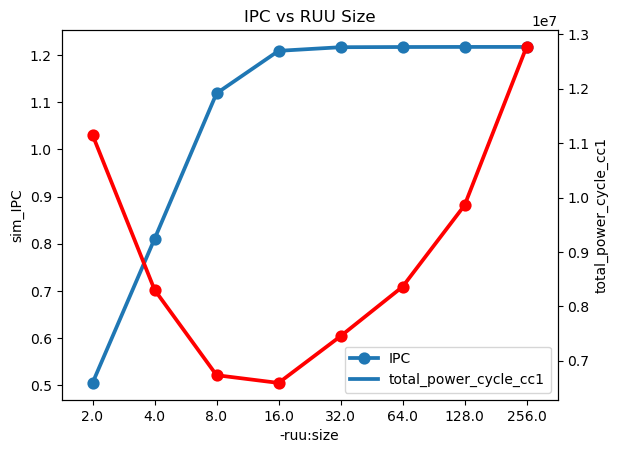

In [5]:

ipc_plot = seaborn.pointplot(results, x='-ruu:size', y='sim_IPC')
ipc_plot.set_title('IPC vs RUU Size')

# Using twinx, we add a second y-axis on the right-hand side which contains total_power_cycle_cc1
ax2 = ipc_plot.twinx()
ax2.set_ylabel('total_power_cycle_cc1')
seaborn.pointplot(results, x='-ruu:size', y='total_power_cycle_cc1', ax=ax2, color='r')

# Show the ledgend so you can tell the two lines apart
ipc_plot.legend(['IPC', 'total_power_cycle_cc1'])

plt.savefig('./report/assets/ipc_vs_ruu_size.png')

In [6]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  {'-ruu:size': 2 ** i, '-lsq:size': 2 ** j}
  # for i in range(2, 8)
  # for j in range(1, 7)
  for i in range(2, 7)
  for j in range(1, 6)
])

/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is d

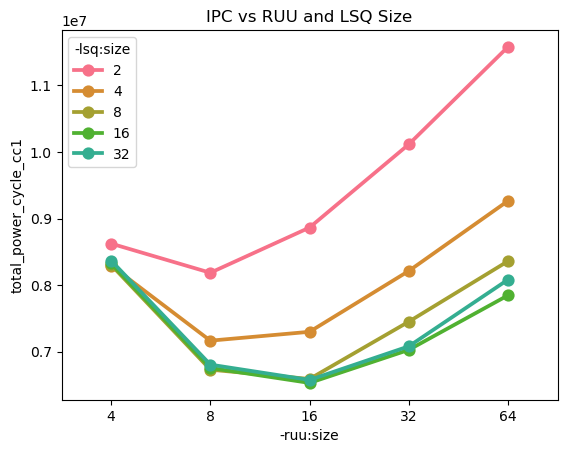

In [7]:
plot_3d(
  results,
  '-ruu:size',
  'total_power_cycle_cc1',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'energy_vs_ruu_and_lsq_size'
)

In [8]:
# Update best params
# best_params = {**best_params, '-lsq:size': 4, '-ruu:size': 8}

In [9]:
# 3. Is RUU or LSQ the bottleneck?
increasing_ruu = run_wattch([
  {'-ruu:size': 2 ** i}
  for i in range(4, 9)
])
increasing_lsq = run_wattch([
  {'-lsq:size': 2 ** i}
  for i in range(3, 8)
])

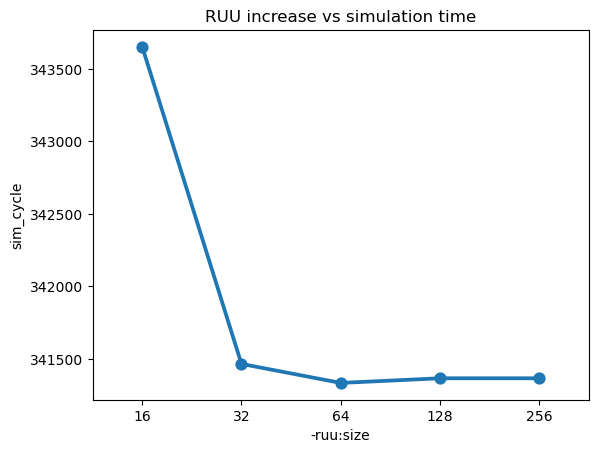

In [10]:

time_plot = seaborn.pointplot(increasing_ruu, x='-ruu:size', y='sim_cycle')
time_plot.set_title('RUU increase vs simulation time')

plt.savefig('./report/assets/ruu_bottleneck.png')

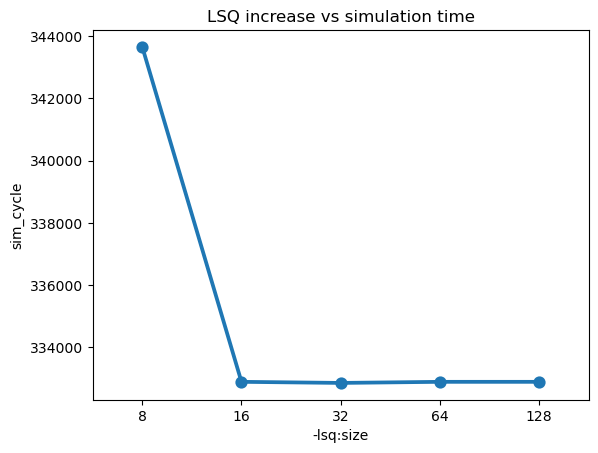

In [11]:
time_plot = seaborn.pointplot(increasing_lsq, x='-lsq:size', y='sim_cycle')
time_plot.set_title('LSQ increase vs simulation time')

plt.savefig('./report/assets/lsq_bottleneck.png')

In [12]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  {'-ruu:size': 2 ** i, '-lsq:size': 2 ** j}
  for i in range(2, 8)
  for j in range(1, 7)
])

/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is d

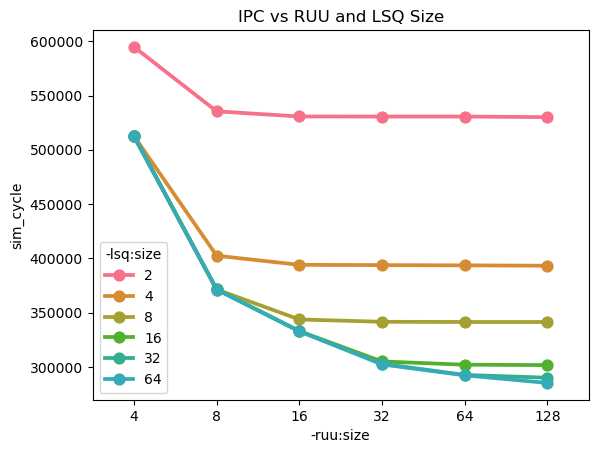

In [13]:
plot_3d(
  results,
  '-ruu:size',
  'sim_cycle',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'ruu_and_lsq_vs_sim_time'
)

# Baseline Energy

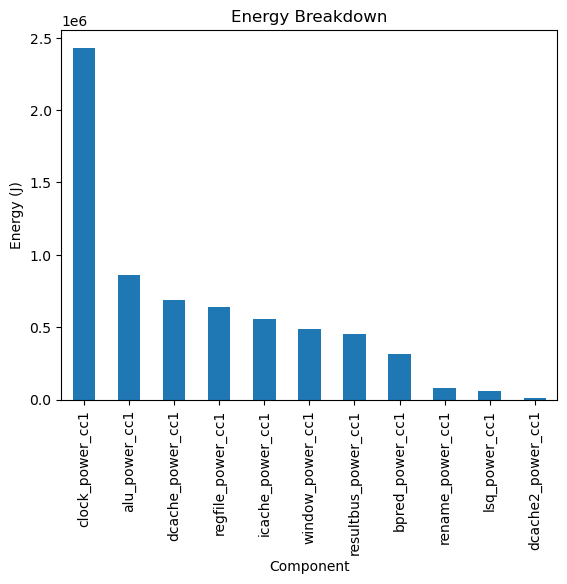

In [14]:
baseline_results = run_wattch([{}], ignore_best=True)

components = ['rename_power_cc1', 'bpred_power_cc1', 'lsq_power_cc1', 'window_power_cc1', 'regfile_power_cc1', 'icache_power_cc1', 'resultbus_power_cc1', 'clock_power_cc1', 'alu_power_cc1', 'dcache_power_cc1', 'dcache2_power_cc1']
# components.append('total_power_cycle_cc1')

energy_data = pd.DataFrame(
  (component, baseline_results[component][0])
  for component in components
)

energy_data = energy_data.sort_values(by=1, ascending=False)

energy_plot = energy_data.plot(x=0, y=1, kind='bar', legend=False)
energy_plot.set_xlabel('Component')
energy_plot.set_ylabel('Energy (J)')
energy_plot.set_title('Energy Breakdown')

plt.savefig('./report/assets/energy_breakdown.png')

# Functional Units

In [15]:
units_results = []

for ifp in ['i', 'fp']:
  for alumult in ['alu', 'mult']:
    results = run_wattch([
      {f'-res:{ifp}{alumult}': f'{i}'}
      for i in [1, 2, 3, 4, 8]
    ])
    results['varied_unit'] = f'{ifp}{alumult}' # f"{'int' if ifp == 'i' else 'float'}{'alu' if alumult == 'alu' else 'mult'}"
    results['varied_unit_n'] = [1, 2, 3, 4, 8]
    units_results.append(results)

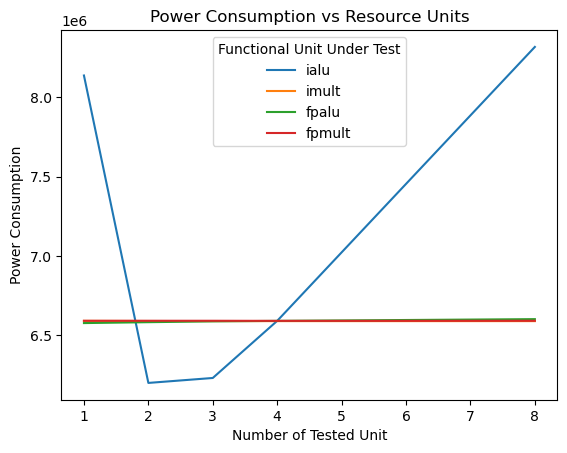

In [16]:
# Concatenate all the results into a single dataframe
results_df = pd.concat(units_results)

# Plot the results
seaborn.lineplot(
  data=results_df,
  x='varied_unit_n',
  y='total_power_cycle_cc1',
  hue='varied_unit'
)

# Set the title and axis labels
plt.title('Power Consumption vs Resource Units')
plt.xlabel('Number of Tested Unit')
plt.ylabel('Power Consumption')

# Show the legend
plt.legend(title='Functional Unit Under Test')

plt.savefig('report/assets/units_vs_energy.png')


In [17]:
register_optimisation('reduce_ialu', {'-res:ialu': 2})

0.0065901242839 0.006206147971199999


# Caches

## L1 Data Cache

In [18]:
bsizes = [8, 16, 32, 64]
csizes = [2 ** i for i in range(8, 12)]
# L1 data cache experiments
l1bsize_cache_results = run_wattch([
  {'-cache:dl1': f'dl1:{(csize//bsize)//4}:{bsize}:4:l'}
  for bsize in bsizes
  for csize in csizes
])
l1bsize_cache_results['bsize'] = [bsize for bsize in bsizes for csize in csizes]
l1bsize_cache_results['csize'] = [csize for bsize in bsizes for csize in csizes]

/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is d

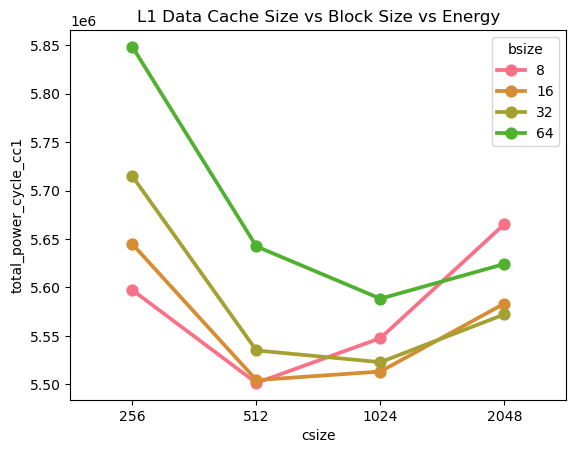

In [19]:
# bsize_vs_energy = seaborn.pointplot(l1bsize_cache_results, x='bsize', y='total_power_cycle_cc1')
# bsize_vs_energy.set_title('Block Size vs Energy')
# plt.savefig('report/assets/l1bsize_vs_energy.png')

plot_3d(
  l1bsize_cache_results,
  'csize',
  'total_power_cycle_cc1',
  'bsize',
  'L1 Data Cache Size vs Block Size vs Energy',
  'l1_vs_energy'
)

In [20]:
# Update best params
register_optimisation('dl1_cache', {'-cache:dl1': 'dl1:8:16:4:l'})

0.006206147971199999 0.005504374687


## L2 Data Cache

In [21]:
bsizes = [2 ** i for i in range(12, 18)]
csizes = [2 ** i for i in range(12, 20)]
# bsizes = [2 ** i for i in range(13, 16)] # 100_000 insertions
# csizes = [2 ** i for i in range(14, 18)]
# L1 data cache experiments
dl2_cache_results = run_wattch([
  {'-cache:dl2': f'ul2:{(csize//bsize)//2}:{bsize}:2:l'}
  for bsize in bsizes
  for csize in csizes
])
dl2_cache_results['bsize'] = [bsize for bsize in bsizes for csize in csizes]
dl2_cache_results['csize'] = [csize for bsize in bsizes for csize in csizes]

/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is d

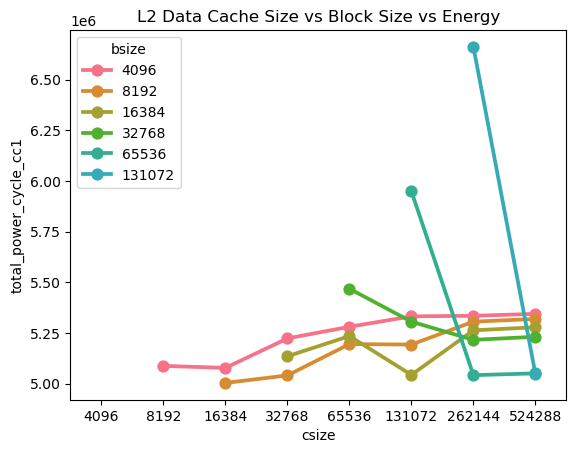

In [22]:
plot_3d(
  dl2_cache_results,
  'csize',
  'total_power_cycle_cc1',
  'bsize',
  'L2 Data Cache Size vs Block Size vs Energy',
  'l2_vs_energy'
)

In [23]:
# register_optimisation('dl2_cache', {'-cache:dl2': 'dl2:8:4096:1:l'}) # 1-way, 100_000 insertions
# register_optimisation('l2_cache', {'-cache:dl2': 'ul2:1:16384:2:l'}) # 2-way, 100_000 insertions
register_optimisation('l2_cache', {'-cache:dl2': 'ul2:2:8192:2:l'}) # 2-way, 100_000 insertions

0.005504374687 0.0050406318163


# Instruction Caches

In [24]:
csizes = [2 ** i for i in range(4, 15)]
l2_icache_size_results = run_wattch([
  {'-cache:il1': f'il1:{csize//64//4}:64:4:l'}
  for csize in csizes
])
l2_icache_size_results['csize'] = csizes

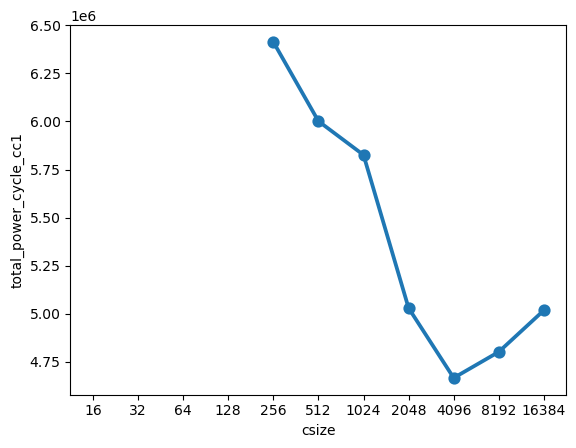

In [25]:
# 16
plot_2d(l2_icache_size_results, 'csize', 'total_power_cycle_cc1')

In [26]:
register_optimisation('il1_cache', {'-cache:il1': 'il1:16:64:4:l'})

0.0050406318163 0.0046657042457


# Branch Predictor

In [30]:
bpred_results = run_wattch([
  {'-bpred': bpred}
  for bpred in ['nottaken', 'taken', 'perfect', 'bimod', '2lev', 'comb']
])

<AxesSubplot:xlabel='-bpred'>

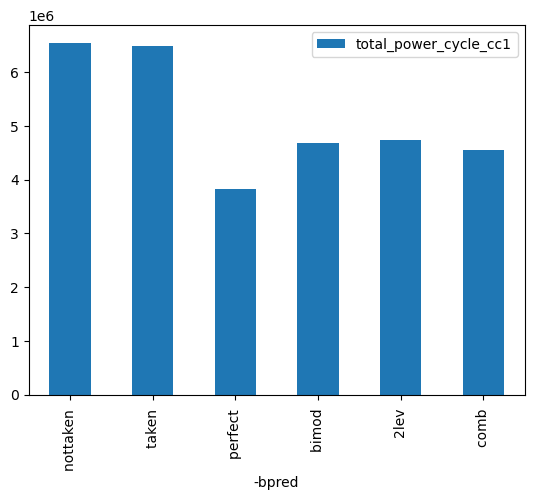

In [31]:
bpred_results.plot(x='-bpred', y='total_power_cycle_cc1', kind='bar')

In [32]:
meta_table_results = run_wattch([
  {'-bpred': 'comb', '-bpred:comb': f'{2 ** i}'}
  for i in range(2, 13)
])

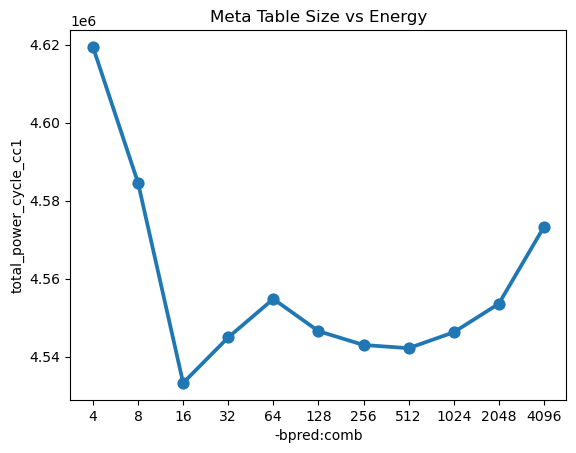

In [36]:
plot_2d(meta_table_results, '-bpred:comb', 'total_power_cycle_cc1', "Meta Table Size vs Energy", "meta_table_vs_energy")

In [35]:
register_optimisation('bpred', {'-bpred': 'comb', '-bpred:comb': 16})

0.004681936326000001 0.0045095586485999995


## BTB

In [39]:
btb_sizes = [2 ** i for i in range(0, 13)]
assocs = [2 ** i for i in range(1, 4)]
btb_size_results = run_wattch([
  {'-bpred:btb': f'{btb_size//assoc} {assoc}'}
  for btb_size in btb_sizes
  for assoc in assocs
])
btb_size_results['btb_size'] = [btb_size for btb_size in btb_sizes for assoc in assocs]
btb_size_results['assoc'] = [assoc for btb_size in btb_sizes for assoc in assocs]

/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_66135/65331513.py:120: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')


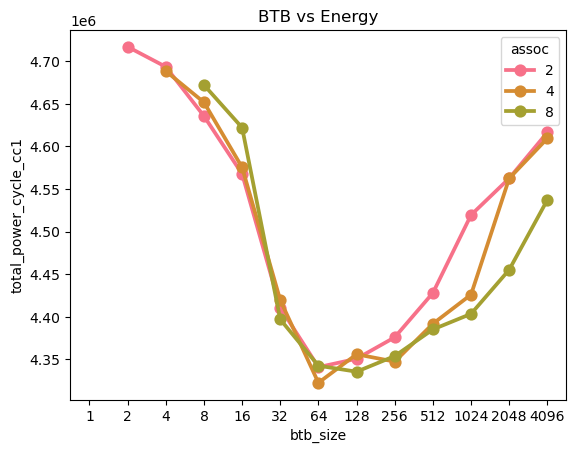

In [42]:
plot_3d(btb_size_results, 'btb_size', 'total_power_cycle_cc1', 'assoc', 'BTB vs Energy', 'btb_vs_energy')

In [43]:
register_optimisation('btb', {'-bpred:btb': '16 4'})

0.0045095586485999995 0.0043226597194


# Width of Issue/Decode/Commit Stages

In [44]:
stage_width_results = []
for stage in ['decode', 'issue', 'commit']:
  for width in [1, 2, 4, 8]:
    results = run_wattch([
      {f'-{stage}:width': f'{width}'}
    ], ignore_best=False)
    results['varied_stage'] = stage
    results['varied_stage_width'] = width
    stage_width_results.append(results)

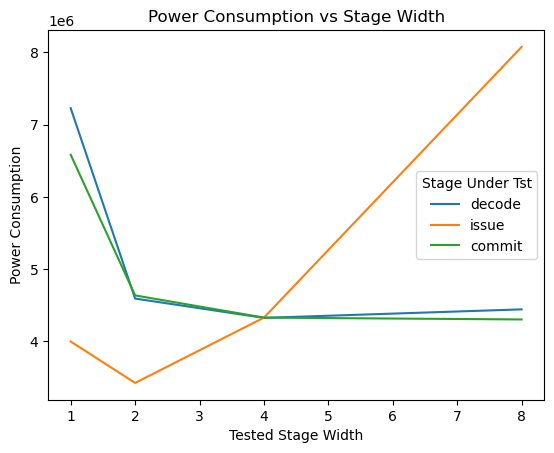

In [47]:
# Concatenate all the results into a single dataframe
results_df = pd.concat(stage_width_results)

# Plot the results
seaborn.lineplot(
  data=results_df,
  x='varied_stage_width',
  y='total_power_cycle_cc1',
  hue='varied_stage'
)

# Set the title and axis labels
plt.title('Power Consumption vs Stage Width')
plt.xlabel('Tested Stage Width')
plt.ylabel('Power Consumption')

# Show the legend
plt.legend(title='Stage Under Tst')

plt.savefig('report/assets/width_vs_energy.png')


In [46]:
register_optimisation('width', {'-issue:width': 2})

0.0043226597194 0.0034125277242


## L1 and L2 Data Cache Associativity

In [320]:
assocs = [2 ** i for i in range(0, 3)]
l2_cache_assoc_results = run_wattch([
  {'-cache:dl1': f'dl1:8:32:{i}:l', '-cache:dl2': f'dl2:256:64:{i}:l'}
  for i in assocs
])
l2_cache_assoc_results['assoc'] = assocs

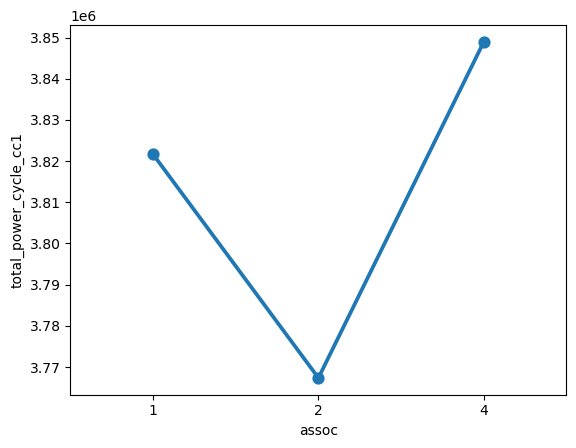

In [321]:
plot_2d(l2_cache_assoc_results, 'assoc', 'total_power_cycle_cc1')

# IFQ

In [322]:
ifq_results = run_wattch([
  {'-fetch:ifqsize': f'{2 ** i}'}
  for i in range(0, 5)
])

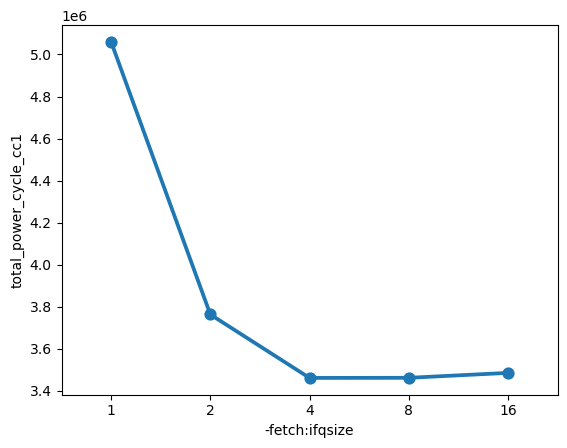

In [323]:
plot_2d(ifq_results, '-fetch:ifqsize', 'total_power_cycle_cc1')

# Summary

In [324]:
best_params

{'-res:ialu': 2,
 '-cache:dl1': 'dl1:8:16:4:l',
 '-cache:dl2': 'ul2:2:8192:2:l',
 '-cache:il1': 'il1:16:64:4:l',
 '-issue:width': 2,
 '-bpred': 'comb',
 '-bpred:comb': 8,
 '-bpred:btb': '1 8'}

In [325]:
baseline_energy = run_wattch([{}])['total_power_cycle_cc1'][0]

removed = list(best_params.keys())
removed_results = run_wattch([
  {i: best_params[i] for i in best_params if i != key}
  for key in removed
], ignore_best=True)
removed_results['removed'] = removed
removed_results['parameter_effectiveness'] = removed_results['total_power_cycle_cc1'] - baseline_energy

<AxesSubplot:xlabel='removed'>

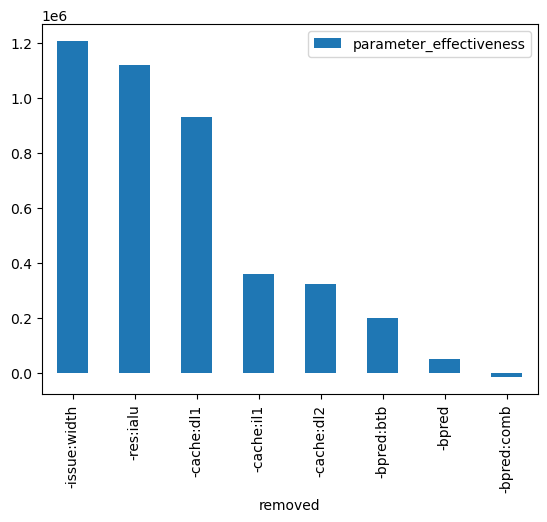

In [326]:
removed_results.sort_values('parameter_effectiveness', ascending=False).plot(x='removed', y='parameter_effectiveness', kind='bar')

In [327]:
best_params

{'-res:ialu': 2,
 '-cache:dl1': 'dl1:8:16:4:l',
 '-cache:dl2': 'ul2:2:8192:2:l',
 '-cache:il1': 'il1:16:64:4:l',
 '-issue:width': 2,
 '-bpred': 'comb',
 '-bpred:comb': 8,
 '-bpred:btb': '1 8'}